In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import pickle

In [33]:
raw_data = pd.read_excel('Online Retail.xlsx')
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [34]:
raw_data.shape

(541909, 8)

In [35]:
raw_data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [36]:
raw_data[raw_data['CustomerID'].isna()].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
210114,555276,75049L,LARGE CIRCULAR MIRROR MOBILE,5,2011-06-01 17:28:00,2.46,NaN,United Kingdom
521803,580367,22969,HOMEMADE JAM SCENTED CANDLES,4,2011-12-02 16:39:00,3.29,NaN,United Kingdom
452956,575477,21931,JUMBO STORAGE BAG SUKI,1,2011-11-09 16:14:00,4.13,NaN,United Kingdom
124348,546974,22297,HEART IVORY TRELLIS SMALL,1,2011-03-18 12:08:00,2.46,NaN,United Kingdom
60285,541421,84711A,SILVER OVAL SHAPE TRINKET BOX,2,2011-01-17 17:44:00,5.79,NaN,United Kingdom


In [37]:
# drop where customer id is not available
clean_data = raw_data.dropna(subset=['CustomerID'])
clean_data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [38]:
clean_data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [39]:
(clean_data['Quantity'] < 0).sum()

8905

In [40]:
# Remove Negative Quantity 
clean_data = clean_data[clean_data['Quantity'] >=0].copy()

In [41]:
clean_data['InvoiceDate'].describe()

count                  397924
unique                  17286
top       2011-11-14 15:27:00
freq                      542
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

#### RFM Feature Engineering

In [42]:
# Compute Monetary Value
clean_data['Monetary'] = clean_data['Quantity'] * clean_data['UnitPrice']

# Compute Recency in days with respect to last date in the dataset
clean_data['Recency'] = (clean_data['InvoiceDate'].describe()['last'] - clean_data['InvoiceDate']).dt.days

In [43]:
# Compute Frequency for each cutomer & generate RFM Feature set
rfm_data = clean_data.groupby(['CustomerID']).agg({'Recency':'min','InvoiceNo':'nunique','Monetary':'sum'}).reset_index()
rfm_data.rename({'InvoiceNo':'Frequency'},axis=1,inplace=True)
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


In [44]:
rfm_data.shape

(4339, 4)

In [45]:
rfm_data.describe()

,CustomerID,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,91.518322,4.271952,2053.793018
std,1721.889758,100.009747,7.705493,8988.248381
min,12346.000000,0.000000,1.000000,0.000000
25%,13812.500000,17.000000,1.000000,307.245000
50%,15299.000000,50.000000,2.000000,674.450000
75%,16778.500000,141.000000,5.000000,1661.640000
max,18287.000000,373.000000,210.000000,280206.020000


### Remove Outliers

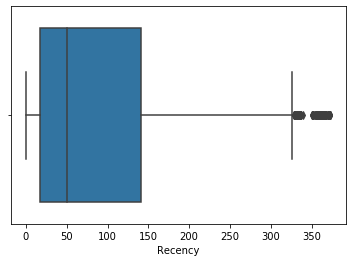

In [46]:
# Recency distribution
sns.boxplot(rfm_data['Recency'])

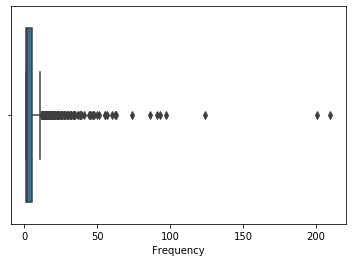

In [47]:
# Frequency distribution
sns.boxplot(rfm_data['Frequency'])

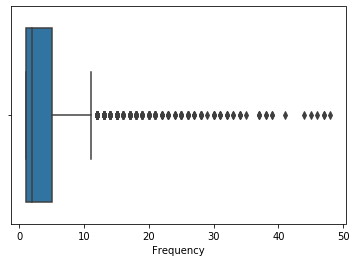

In [48]:
# Removing Frequency outliers
clean_rfm = rfm_data[rfm_data['Frequency']<50].copy()
sns.boxplot(clean_rfm['Frequency'])

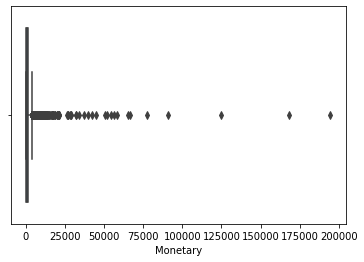

In [49]:
# Monetary distribution
sns.boxplot(clean_rfm['Monetary'])

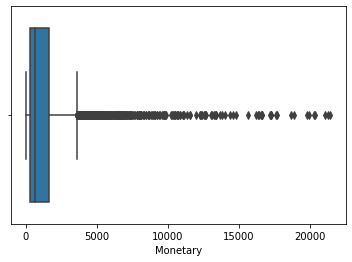

In [50]:
# Removing Monetary outliers
clean_rfm = clean_rfm[clean_rfm['Monetary']<=25000].copy()
sns.boxplot(clean_rfm['Monetary'])

In [51]:
clean_rfm.shape

(4298, 4)

In [52]:
# Total Customers Removed
rfm_data.shape[0]-clean_rfm.shape[0]

41

### RFM Visualization

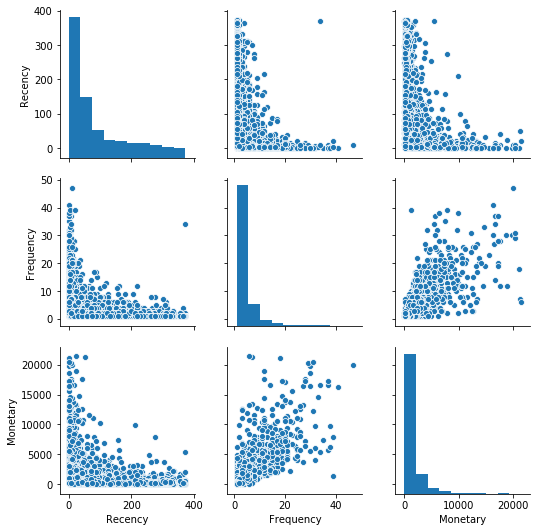

In [53]:
sns.pairplot(clean_rfm[['Recency','Frequency','Monetary']])

### Correlation Analysis

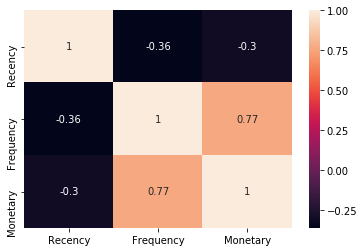

In [54]:
# Compute the correlation matrix
corr = clean_rfm[['Recency','Frequency','Monetary']].corr()

# Draw the heatmap 
sns.heatmap(corr,annot=True)

#####  *Insight from PairPlot and Correlation Analysis: Frequency & Monetary are highly Postively Corretated*

### Feature Scaling


In [55]:
scaler = MinMaxScaler()
scaled_rfm = clean_rfm.copy()
scaled_rfm[['Recency','Frequency','Monetary']] = scaler.fit_transform(scaled_rfm[['Recency','Frequency','Monetary']])
scaled_rfm.head()

,CustomerID,Recency,Frequency,Monetary
1,12347.0,0.002681,0.130435,0.201126
2,12348.0,0.198391,0.065217,0.083868
3,12349.0,0.048257,0.000000,0.082016
4,12350.0,0.828418,0.000000,0.015605
5,12352.0,0.093834,0.152174,0.116944


In [56]:
scaled_rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4298.000000,4298.000000,4298.000000,4298.000000
mean,15301.723127,0.247099,0.061798,0.066798
std,1721.937843,0.268259,0.099059,0.103336
min,12347.000000,0.000000,0.000000,0.000000
25%,13814.250000,0.045576,0.000000,0.014273
50%,15302.000000,0.134048,0.021739,0.030981
75%,16780.750000,0.380697,0.086957,0.075353
max,18287.000000,1.000000,1.000000,1.000000


### Clustering

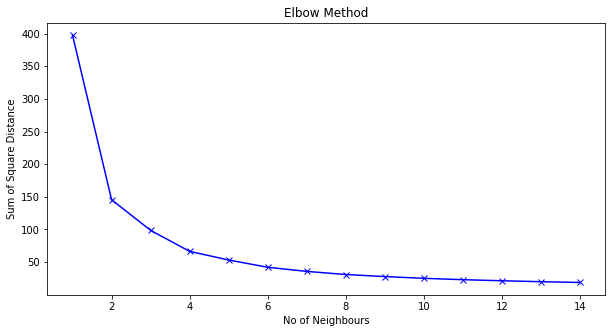

In [57]:
# Elbow Plot
inertia = []
neighbour_range = range(1,15)
for k in neighbour_range:
    cluster = KMeans(n_clusters=k)
    cluster = cluster.fit(scaled_rfm[['Recency','Frequency','Monetary']])
    inertia.append(cluster.inertia_)

plt.figure(figsize=(10,5))
plt.plot(neighbour_range, inertia, 'bx-')
plt.xlabel('No of Neighbours')
plt.ylabel('Sum of Square Distance')
plt.title('Elbow Method')
plt.show()

In [58]:
No_of_cluster = 4
cluster = KMeans(n_clusters=No_of_cluster, random_state=42)
cluster.fit(scaled_rfm[['Recency','Frequency','Monetary']])
scaled_rfm['Cluster'] = cluster.predict(scaled_rfm[['Recency','Frequency','Monetary']])
scaled_rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
1,12347.0,0.002681,0.130435,0.201126,2
2,12348.0,0.198391,0.065217,0.083868,2
3,12349.0,0.048257,0.000000,0.082016,2
4,12350.0,0.828418,0.000000,0.015605,3
5,12352.0,0.093834,0.152174,0.116944,2


### Cluster Visualization


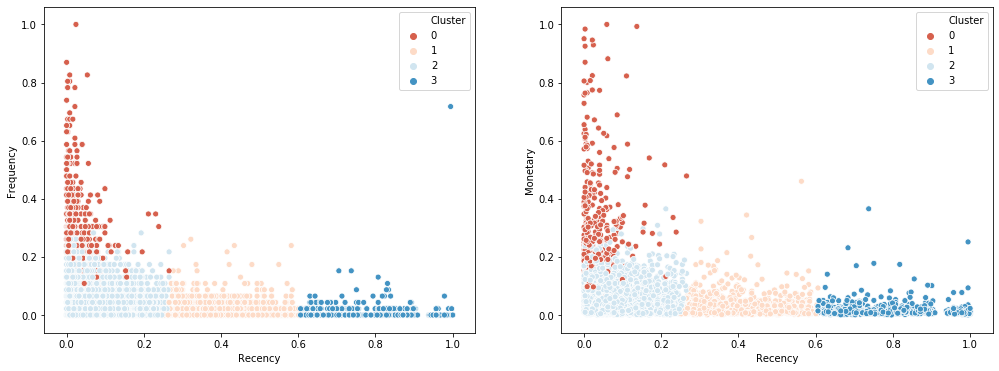

In [59]:
palette= sns.color_palette("RdBu", n_colors=No_of_cluster)
fig, axes = plt.subplots(1, 2,figsize=(17,6))
sns.scatterplot(y="Frequency", x= "Recency", hue='Cluster', data=scaled_rfm, ax=axes[0], palette=palette)
sns.scatterplot(y="Monetary",  x= "Recency", hue='Cluster', data=scaled_rfm, ax=axes[1], palette=palette)

### Cluster Centers

In [60]:
cluster_center = cluster.cluster_centers_
cluster_center = pd.DataFrame(scaler.inverse_transform(cluster_center),columns=[['Recency','Frequency','Monetary']])
cluster_center.reset_index(inplace=True)
cluster_center.rename({'index':'Cluster'},axis=1,inplace=True)
cluster_center = cluster_center.round()
cluster_center

,Cluster,Recency,Frequency,Monetary
0,0,13.0,16.0,7417.0
1,1,156.0,2.0,706.0
2,2,35.0,3.0,1186.0
3,3,294.0,1.0,412.0


### Business interpretation of Clustering

1.   Cluster 0 are highly recent, highly frequent and have high monetary value
2.   Cluster 1, 2, & 3, are less frequent and have less monetary value.Only differentiating factor for them is their Recency
2.   Business should focus on increasing frequency for Cluster 1, 2, & 3 as Frequency is highly correlated with Monetary value. 






### Labeling CLustering 

In [61]:
cluster_encode = {0:'Platinum',2:'Gold',1:'Silver',3:'Bronze'}
scaled_rfm['Customer_Segment'] = scaled_rfm['Cluster'].map(cluster_encode)
scaled_rfm['Customer_Segment'].value_counts()

Gold        2607
Silver       769
Bronze       617
Platinum     305
Name: Customer_Segment, dtype: int64

#### Business should devise strategy to move Gold category customer to Platinum category, Silver to Gold and Bronze to Silver


#### Saving Model


In [62]:
pickle.dump(scaler, open("scaler.pkl", "wb"))
pickle.dump(cluster, open("cluster.pkl", "wb"))
pickle.dump(cluster_encode, open("cluster_encode.pkl", "wb"))